In [12]:
import torch
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net

### One-hot-encoding for categorical attributes

In [13]:
# Read file and store as pandas dataframe
filename = '../Data/day.csv'
df = pd.read_csv(filename)

for attribute in ['instant','dteday','yr','mnth','holiday','weekday','casual','registered']:
    df = df.drop(attribute, axis=1)
    
# One hot encoding
ohe_df = pd.get_dummies(df, columns = ['season','weathersit'])
ohe_df = ohe_df.drop(['season_4','weathersit_3'], axis=1)    # season_4, weathersit_3 are chosen as reference variables
display(ohe_df)

,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,weathersit_1,weathersit_2
0,0,0.344167,0.363625,0.805833,0.160446,985,1,0,0,0,1
1,0,0.363478,0.353739,0.696087,0.248539,801,1,0,0,0,1
2,1,0.196364,0.189405,0.437273,0.248309,1349,1,0,0,1,0
3,1,0.200000,0.212122,0.590435,0.160296,1562,1,0,0,1,0
4,1,0.226957,0.229270,0.436957,0.186900,1600,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
726,1,0.254167,0.226642,0.652917,0.350133,2114,1,0,0,0,1
727,1,0.253333,0.255046,0.590000,0.155471,3095,1,0,0,0,1
728,0,0.253333,0.242400,0.752917,0.124383,1341,1,0,0,0,1
729,0,0.255833,0.231700,0.483333,0.350754,1796,1,0,0,1,0


### Standardize data

In [14]:
N, M = ohe_df.shape
attribute_names = list(ohe_df.columns)

# Get column indexes
temp_col = ohe_df.columns.get_loc("temp")
atemp_col = ohe_df.columns.get_loc("atemp")
hum_col = ohe_df.columns.get_loc("hum")
wspd_col = ohe_df.columns.get_loc("windspeed")
cnt_col = ohe_df.columns.get_loc("cnt")

# Undo the original max-min normalization
data = ohe_df.values
for row in range(0, N):
    data[row, temp_col] = data[row, temp_col]*(39-(-8)) + (-8)
    data[row, atemp_col] = data[row, atemp_col]*(50-(-16)) + (-16)
    data[row, hum_col] = data[row, hum_col]*100
    data[row, wspd_col] = data[row, wspd_col]*67

# Standarize ratio data attributes
for col in range(temp_col, cnt_col+1): # subtract mean column-wise
    mn = data[:, col].mean(0)
    std = np.std(data[:, col])
    data[:, col] = (data[:, col] - np.ones(N)*mn)/std

# Create DataFrame for visualisation
data_df = pd.DataFrame(data, columns=attribute_names)
display(data_df)

,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,weathersit_1,weathersit_2
0,0.0,-0.826662,-0.679946,1.250171,-0.387892,-1.817953,1.0,0.0,0.0,0.0,1.0
1,0.0,-0.721095,-0.740652,0.479113,0.749602,-1.912999,1.0,0.0,0.0,0.0,1.0
2,1.0,-1.634657,-1.749767,-1.339274,0.746632,-1.629925,1.0,0.0,0.0,1.0,0.0
3,1.0,-1.614780,-1.610270,-0.263182,-0.389829,-1.519898,1.0,0.0,0.0,1.0,0.0
4,1.0,-1.467414,-1.504971,-1.341494,-0.046307,-1.500269,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,-1.318665,-1.521108,0.175807,2.061426,-1.234757,1.0,0.0,0.0,0.0,1.0
727,1.0,-1.323224,-1.346690,-0.266238,-0.452131,-0.728012,1.0,0.0,0.0,0.0,1.0
728,0.0,-1.323224,-1.424344,0.878392,-0.853552,-1.634057,1.0,0.0,0.0,0.0,1.0
729,0.0,-1.309558,-1.490049,-1.015664,2.069444,-1.399023,1.0,0.0,0.0,1.0,0.0


### Set 'cnt' as target variable

In [15]:
# Split dataset into features and target vector
cnt_col = attribute_names.index("cnt")
y = data[:,cnt_col]
X = np.delete(data, cnt_col, axis=1)
attribute_names.pop(cnt_col)
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attribute_names = [u'offset']+attribute_names
M = M+1

print("N: {}, M: {} (including offset)".format(N,M))

N: 731, M: 11 (including offset)


In [16]:
attribute_names

['offset',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season_1',
 'season_2',
 'season_3',
 'weathersit_1',
 'weathersit_2']

### 1. Regularized Linear Regression

In [17]:
# Values of lambda
lambdas = np.power(10.,np.linspace(-5,9,100))

### 2. Artificial Neural Network

In [18]:
# Define the ANN model structure
n_hidden_units = 4
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 15000

model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU()   
                    torch.nn.Linear(n_hidden_units, 1) # H hidden units to 1 output neuron
                    )
loss_fn = torch.nn.MSELoss()
print('Training model of type:\n\n{}\n'.format(str(model())))

Training model of type:

Sequential(
  (0): Linear(in_features=11, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)



### Cross Validation

In [19]:
# Cross validation
K_outer = 4
K_inner = 2

cv_outer = model_selection.KFold(K_outer, shuffle=False)
cv_inner = model_selection.KFold(K_inner, shuffle=False)

In [20]:
# Initialize variables
Error_par = np.empty((K_outer,1))
Error_test = np.empty((K_outer,1))
Error_par_rlr = np.empty((K_outer,1))
Error_test_rlr = np.empty((K_outer,1))
Error_par_nofeatures = np.empty((K_outer,1))
Error_test_nofeatures = np.empty((K_outer,1))
Error_test_ANN = np.empty((K_outer,1))

opt_hs = np.zeros((K_outer,1))                   # optimal ANN hidden units for each outer fold
opt_lambdas = np.empty((K_outer,1))             # optimal lambdas for each outer fold
w_rlr = np.empty((M,K_outer))                   # weights for each attribute with regularisation
w_noreg = np.empty((M,K_outer))                 # weights for each attribute without regularisation
mu = np.empty((K_outer, M-1))
sigma = np.empty((K_outer, M-1))

### Training and Testing


Outer Cross Validation Fold: 1/4

	Inner Cross Validation Fold: 1/2

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.16308315	0.00028609383
		2000	0.1331773	0.00014733696
		3000	0.11559641	0.00012901904
		4000	0.10479307	6.298888e-05
		5000	0.099811725	4.239733e-05
		6000	0.09624129	2.9649309e-05
		7000	0.09375692	2.6143956e-05
		8000	0.0909185	3.3515567e-05
		9000	0.08843807	1.9544761e-05
		10000	0.0872105	1.0849765e-05
		11000	0.08612781	1.4186799e-05
		12000	0.08511067	9.191606e-06
		13000	0.08451742	5.3773883e-06
		14000	0.084101416	4.87245e-06
		15000	0.08367104	5.342738e-06
		Final loss:
		15000	0.08367104	5.342738e-06

	Best loss: 0.08367104083299637


	Inner Cross Validation Fold: 2/2

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.101489246	0.00031256618
		2000	0.08053513	0.000118495656
		3000	0.07202586	0.00012018648
		4000	0.063837476	0.000115297866
		5000	0.05624567	0.0001213894
		6000	0.052426197	4.1993397e-05
		7000	0.049256425	0.00011774289
		8000	0.045850016	4.44414

Text(0.5, 1.0, 'Test mean-squared-error')

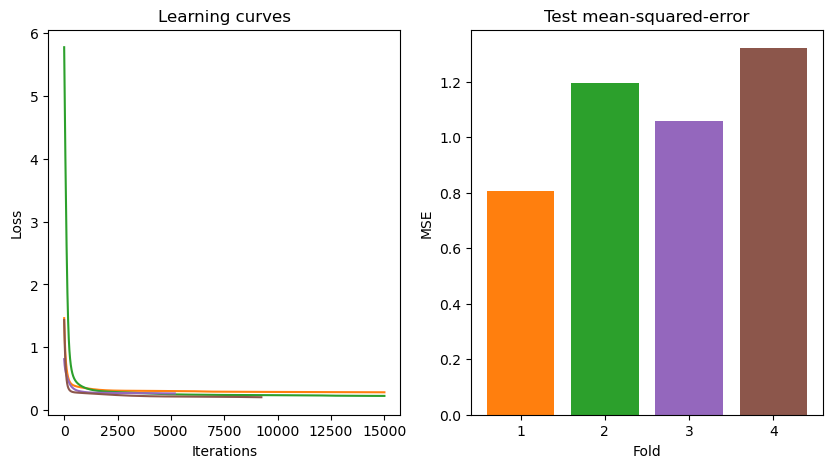

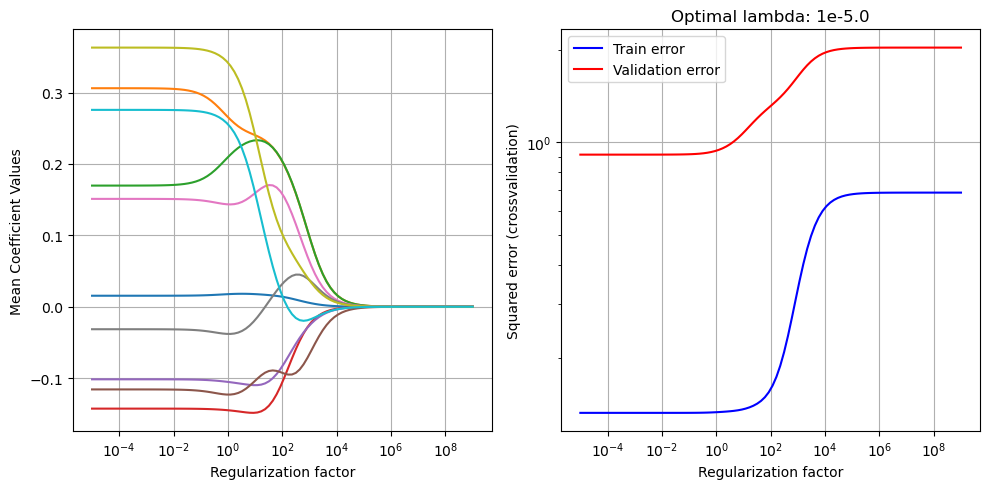

In [21]:
# Setup figure for display of ANN summaries
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10,5),num=2)
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

for k_out, (par_index, test_index) in enumerate(cv_outer.split(X,y)):
    
    print('\nOuter Cross Validation Fold: {0}/{1}'.format(k_out+1,K_outer))
    
    # Split outer fold into parameterisation set and test set
    X_par = X[par_index]
    y_par = y[par_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    # Initialise
    w = np.empty((M,K_inner,len(lambdas)))
    train_error = np.empty((K_inner,len(lambdas)))
    val_error = np.empty((K_inner,len(lambdas)))
    test_error = np.empty((K_inner,len(lambdas)))
    y_par = y_par.squeeze()
    
    # test out two possible number of hidden units for now
    ann_val_error = np.empty((K_inner,2))
    ann_test_error = np.empty((K_inner,2))
    
    for k_in, (train_index, val_index) in enumerate(cv_inner.split(X_par,y_par)):
    
        print('\n\tInner Cross Validation Fold: {0}/{1}'.format(k_in+1,K_inner))
        
        # Split parameterisation set into training set and validation set
        X_train = X[train_index]
        y_train = y[train_index]
        X_val = X[val_index]
        y_val = y[val_index]
    
        ########################### Lingear Regression ###########################
        # Standardize inner fold based on training set, and save the mean and std
        mu[k_in, :] = np.mean(X_train[:, 1:], 0)
        sigma[k_in, :] = np.std(X_train[:, 1:], 0)

        X_train[:, 1:] = (X_train[:, 1:] - mu[k_in, :] ) / sigma[k_in, :]
        X_val[:, 1:] = (X_val[:, 1:] - mu[k_in, :] ) / sigma[k_in, :]

        # Precompute terms
        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train

        # solve for weights
        for l in range(0,len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            lambdaI = lambdas[l] * np.eye(M)
            lambdaI[0,0] = 0 # remove bias regularization
            w[:,k_in,l] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
            # Evaluate training and test performance
            train_error[k_in,l] = np.power(y_train-X_train @ w[:,k_in,l].T,2).mean(axis=0)
            val_error[k_in,l] = np.power(y_test-X_test @ w[:,k_in,l].T,2).mean(axis=0)
    
        opt_val_err = np.min(np.mean(val_error,axis=0))
        opt_lambda = lambdas[np.argmin(np.mean(val_error,axis=0))]
        train_err_vs_lambda = np.mean(train_error,axis=0)
        val_err_vs_lambda = np.mean(val_error,axis=0)
        mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))
        
        
        ############################### ANN ###############################
        # Convert train and val sets into tensors
        X_train = torch.Tensor(X[train_index,:])
        y_train = torch.Tensor(y[train_index]).reshape(-1,1)
        X_val = torch.Tensor(X[val_index,:])
        y_val = torch.Tensor(y[val_index]).reshape(-1,1)
        
        # TODO: make for-loop to train 2 ANN models with different no of hidden units
        
        # Train the net
        net, final_loss, learning_curve = train_neural_net(model,
                                                           loss_fn,
                                                           X=X_train,
                                                           y=y_train,
                                                           n_replicates=n_replicates,
                                                           max_iter=max_iter)
        print('\n\tBest loss: {}\n'.format(final_loss))

        # Determine estimated values for validation set
        y_val_est = net(X_val)
        
        se_val = (y_val_est.squeeze().float()-y_val.squeeze().float())**2  # squared error
        mse_val = (sum(se_val).type(torch.float)/len(y_val)).data.numpy()      # mean squared error
        
        ## TODO
        # Calculate y_val for different models with different number of hidden units
        # Find optimal number of hidden units
        # Calculate mse using parameterisation set
   
    ########################### Lingear Regression ###########################
    # Save optimal RLR hyperparameter from inner fold
    opt_lambdas[k_out] = opt_lambda
    
    # Retrain linear regression model on parameterisation set using optimal lambda
    Xty_par = X_par.T @ y_par
    XtX_par = X_par.T @ X_par
    
    #### Estimate weights using parameterisation set
    # for the optimal value of lambda
    opt_lambda_I = opt_lambda * np.eye(M)
    opt_lambda_I[0,0] = 0 # remove bias regularization
    w_rlr[:,k_out] = np.linalg.solve(Xty_par+opt_lambda_I,Xty_par).squeeze()
    
    # for unregularized linear regression
    w_noreg[:,k_out] = np.linalg.solve(XtX_par,Xty_par).squeeze()
    
    #### Compute mean squared error 
    # with regularization with optimal lambda
    Error_par_rlr[k_out] = np.square(y_par-X_par @ w_rlr[:,k_out]).sum(axis=0)/y_par.shape[0]
    y_est_rlr = X_test @  w_rlr[:,k_out]
    Error_test_rlr[k_out] = np.square(y_test-y_est_rlr).sum(axis=0)/y_test.shape[0]
    
    # without using the input data
    Error_par_nofeatures[k_out] = np.square(y_par-y_par.mean()).sum(axis=0)/y_par.shape[0]
    Error_test_nofeatures[k_out] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # without regularization
    Error_par[k_out] = np.square(y_par-X_par @ w_noreg[:,k_out]).sum(axis=0)/y_par.shape[0]
    Error_test[k_out] = np.square(y_test-X_test @ w_noreg[:,k_out]).sum(axis=0)/y_test.shape[0]


    
    
    ##################################### ANN #####################################
    # Convert test set into tensors
    X_par = torch.Tensor(X[par_index])
    y_par = torch.Tensor(y[par_index]).reshape(-1,1)
    X_test = torch.Tensor(X[test_index])
    y_test = torch.Tensor(y[test_index]).reshape(-1,1)
    
    # Save optimal ANN hyperparameter from inner fold
    opt_h = 0 # TODO
    opt_hs[k_out] = opt_h
    
    # Retrain ANN on parameterisation set using optimal number of hidden units
    print("\tRetraining ANN using optimal number of hidden units")
    opt_net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_par,
                                                       y=y_par,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    y_test_est = opt_net(X_test)
    
    # Determine ANN test error
    se_test = (y_test_est.squeeze().float()-y_test.squeeze().float())**2     # squared error
    mse_test = (sum(se_test).type(torch.float)/len(y_test)).data.numpy()
    Error_test_ANN[k_out] = mse_test                     # store error rate for current CV fold
    
    print("\n\tANN Test Error for Outer Fold {}/{}: {}".format(k_out+1,K_outer,np.round(mse_test,3)))
    
    
    ############################### DISPLAY RESULTS ###############################
    # Display the learning curve for the best net in the current outer fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k_out])
    h.set_label('CV fold {0}'.format(k_out+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')

   # Display the results for the last cross-validation fold
    if k_out == K_outer-1:
        reg_fig, reg_axes = plt.subplots(1, 2, figsize=(10,5),num=1)
        reg_axes[0].semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'-') # Don't plot the bias term
        reg_axes[0].set_xlabel('Regularization factor')
        reg_axes[0].set_ylabel('Mean Coefficient Values')
        reg_axes[0].grid()

        reg_axes[1].set_title('Optimal lambda: 1e{0}'.format(round(np.log10(opt_lambdas[k_out][0]),5)))
        reg_axes[1].loglog(lambdas,train_err_vs_lambda.T,'b-',lambdas,val_err_vs_lambda.T,'r-')
        reg_axes[1].set_xlabel('Regularization factor')
        reg_axes[1].set_ylabel('Squared error (crossvalidation)')
        reg_axes[1].legend(['Train error','Validation error'])
        reg_axes[1].grid()
        reg_fig.tight_layout()

# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K_outer+1), np.squeeze(np.asarray(Error_test_ANN)), color=color_list)
summaries_axes[1].set_xlabel('Fold')
summaries_axes[1].set_xticks(np.arange(1, K_outer+1))
summaries_axes[1].set_ylabel('MSE')
summaries_axes[1].set_title('Test mean-squared-error')

### Results of Linear Regression

In [22]:
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_par.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_par_nofeatures.sum()-Error_par.sum())/Error_par_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_par_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_par_nofeatures.sum()-Error_par_rlr.sum())/Error_par_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

Linear regression without feature selection:
- Training error: 0.3596648950821674
- Test error:     1.1760337655357107
- R^2 train:     0.6245112065378622
- R^2 test:     -0.8974078868573894

Regularized linear regression:
- Training error: 1.797556907653362e+17
- Test error:     8.626322207819603e+16
- R^2 train:     -1.8766426294678925e+17
- R^2 test:     -1.3917671644601222e+17



Text(0.5, 1.0, 'Weights from each fold of Regularized Linear Regression')

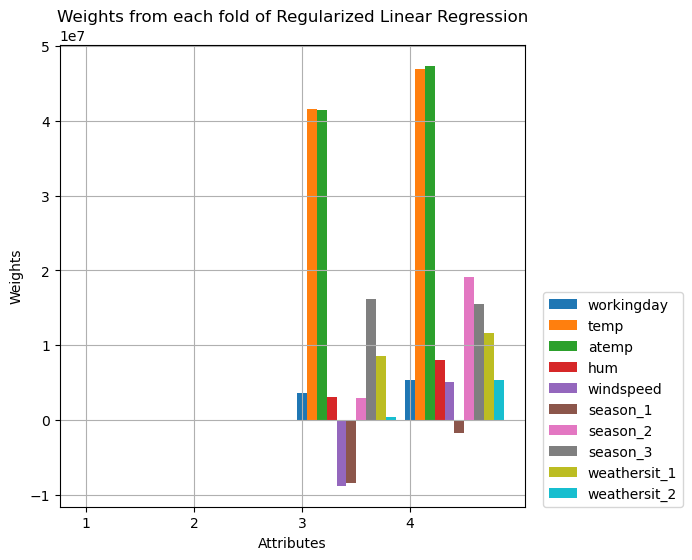

In [23]:
# Bar plot of RLR weights
weights = range(1,M)      # skip offset
bw = 1.0/(len(weights)+1)
r = np.arange(1,K_outer+1)

plt.figure(figsize=(6,6), num=3)
for i in weights:
    plt.bar(r+i*bw, w_rlr[i,:], width=bw)
plt.xticks(r+bw, range(1,K_outer+1))
plt.xlabel('Attributes')
plt.ylabel('Weights')
plt.legend(attribute_names[1:M+1], loc=(1.04, 0))
plt.grid()
plt.title('Weights from each fold of Regularized Linear Regression')

### Results of ANN

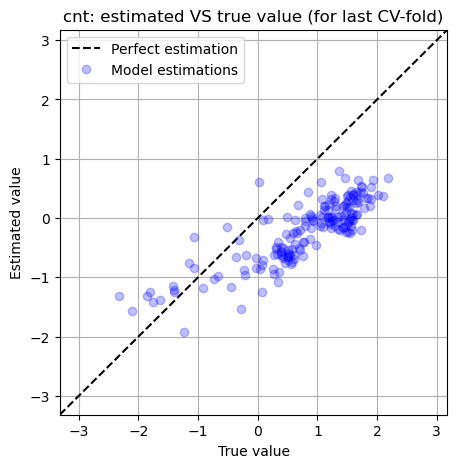

In [24]:
plt.figure(figsize=(5,5),num=5)
y_est = y_test_est.data.numpy().squeeze()
y_true = y_test.data.numpy().squeeze()
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')           # perfect estimation
plt.plot(y_true, y_est,'ob',alpha=.25)          # ANN estimation
plt.legend(['Perfect estimation','Model estimations'])
plt.title('cnt: estimated VS true value (for last CV-fold)')
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()

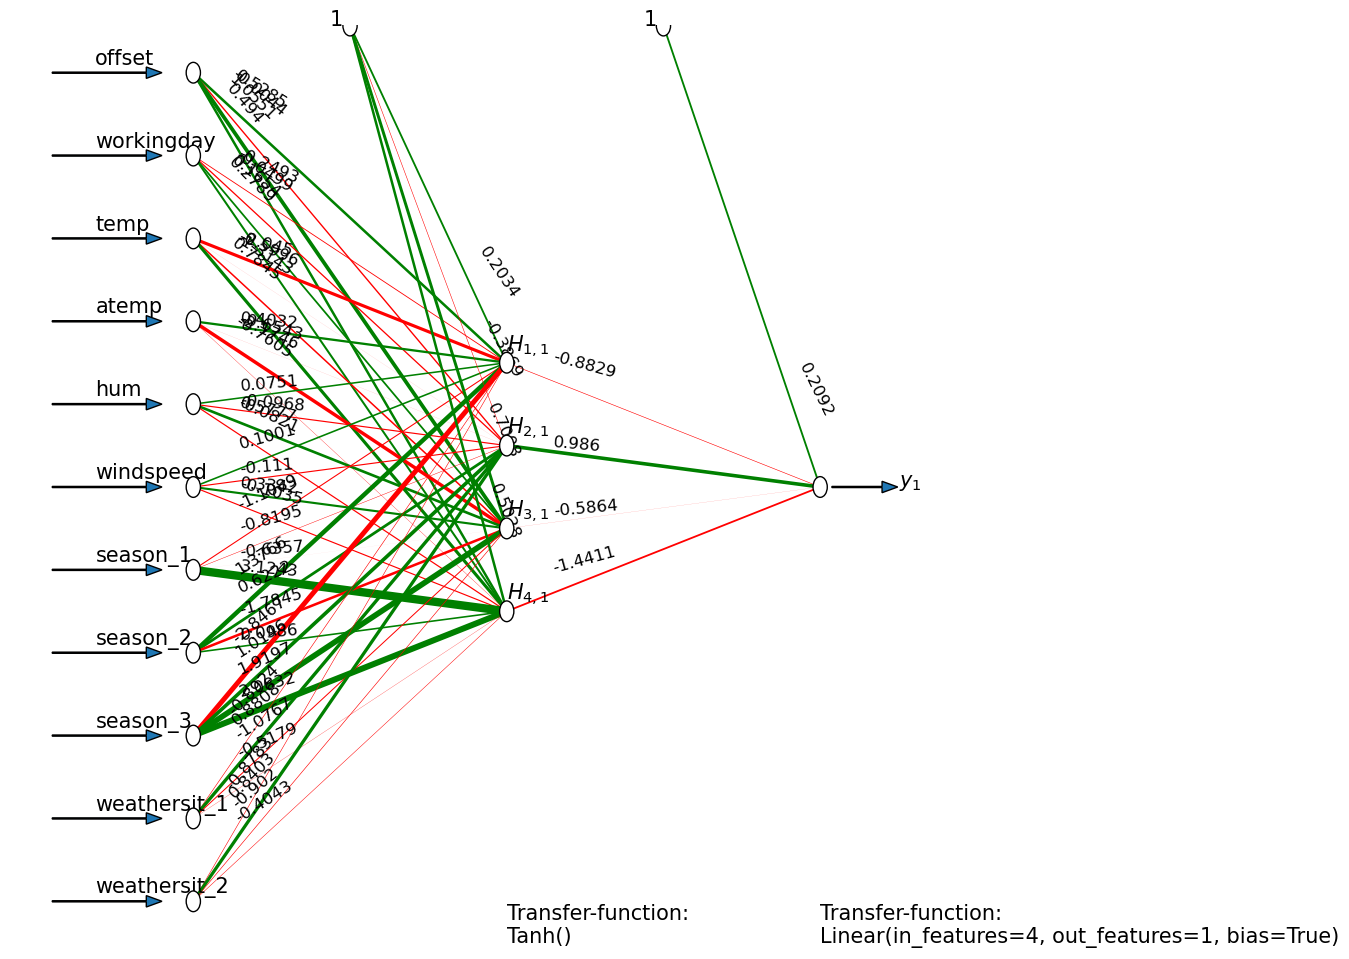

In [25]:
# Diagram of best neural net in last fold
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,2]]
draw_neural_net(weights, biases, tf, attribute_names=attribute_names)

plt.show()

### Table 2

In [28]:
print("Outer fold \tANN \t\t\tLinear Regression \t\tBaseline")
print("--------------------------------------------------------------------------------")
print("i \t\th∗_i \tEtest_i \tlambda_i \tEtest_i \tEtest_i")
for i in range(K_outer):
    print("{} \t\t{:.3f} \t{:.3f} \t\t{:.2e} \t{:.2e} \t\t{:.3f}".format(\
        i+1,opt_hs[i][0],Error_test_ANN[i].item(),opt_lambdas[i][0],\
            Error_test_rlr[i][0],Error_test_nofeatures[i][0]))

Outer fold 	ANN 			Linear Regression 		Baseline
--------------------------------------------------------------------------------
i 		h∗_i 	Etest_i 	lambda_i 	Etest_i 	Etest_i
1 		0.000 	0.807 		2.26e+02 	1.31e+01 		0.581
2 		0.000 	1.195 		5.99e+02 	9.51e+01 		0.307
3 		0.000 	1.058 		1.00e-05 	2.74e+17 		0.773
4 		0.000 	1.322 		1.00e-05 	7.08e+16 		0.817
